In [16]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from src.data import get_data
from src.util import common

import pickle

p=print

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""
Import Data.
"""

Ty=1
Tx=72

X_train=pd.read_csv('../data/processed/X_train_tx{}_ty{}.csv'.format(Tx, Ty))
Y_train=pd.read_csv('../data/processed/Y_train_tx{}_ty{}.csv'.format(Tx, Ty))
X_test=pd.read_csv('../data/processed/X_test_tx{}_ty{}.csv'.format(Tx, Ty))
Y_test=pd.read_csv('../data/processed/Y_test_tx{}_ty{}.csv'.format(Tx, Ty))

N_FEATURES=int(X_train.columns.values.size / Tx)

In [9]:
from xgboost import XGBRegressor

parameters = {
  'objective':'reg:linear',
  'learning_rate': .07, #so called `eta` value
  'max_depth': 10,
  'min_child_weight': 4,
  'silent': 1,
  'subsample': 0.7,
  'colsample_bytree': 0.7,
  'n_estimators': 128
}

xgb_reg=XGBRegressor(**parameters)

In [29]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    'max_depth':[3,4,5,6]
}
xgb_grid = GridSearchCV(
    xgb_reg,
    grid_params,
    scoring='neg_mean_absolute_error',
    cv = 2,
    n_jobs = -1,
    verbose=True,
)

In [30]:
xgb_grid.fit(X_train, Y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/metrics/scorer.py

GridSearchCV(cv=2, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=4, min_child_weight=4, missing=None, n_estimators=128,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='mean_absolute_error', verbose=True)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

xgb_predict=xgb_grid.predict(X_test)

p(mean_absolute_error(xgb_predict, Y_test))
p(mean_squared_error(xgb_predict, Y_test))

print(xgb_grid.best_params_)

0.4408085314115375
0.6516710985463546
{'max_depth': 4}


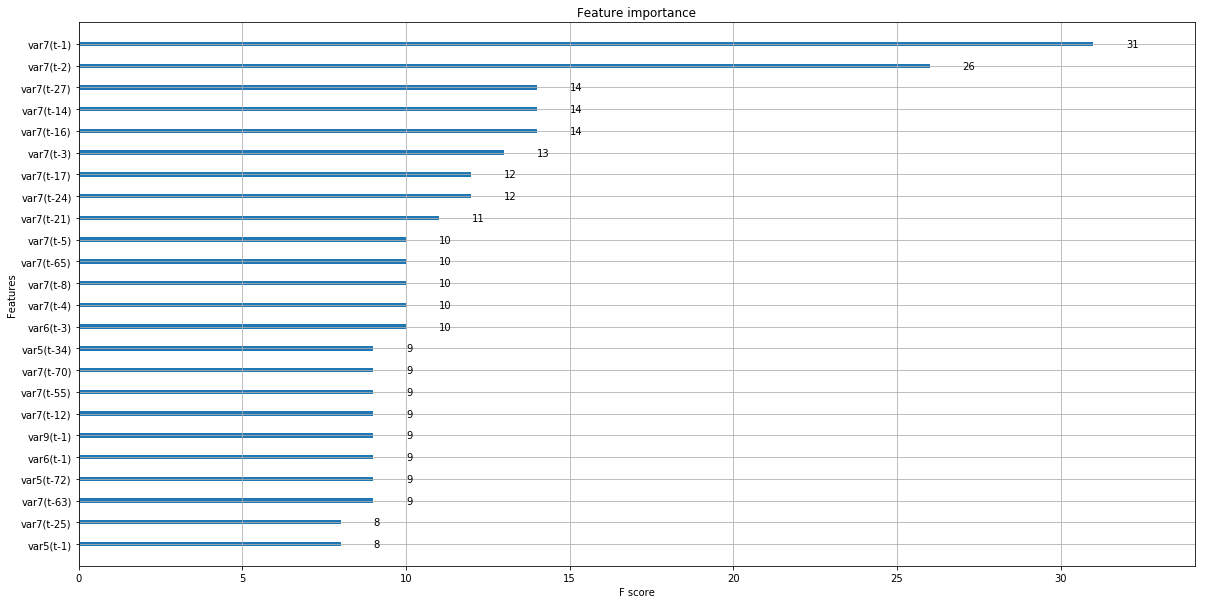

In [34]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20, 10))
plot_importance(ax=ax, booster=xgb_grid.best_estimator_, max_num_features=24)

In [35]:
xgb_reg = xgb_reg.set_params(**xgb_grid.best_params_)
scorestrain=[]
scorescv=[]
iterations=[]

for i in range(500,len(X_train),500) :                
    print(i)
    xgb_reg.fit(X_train[:i], Y_train[:i], 
                early_stopping_rounds=50, 
                eval_metric="mae",
                eval_set=[(X_test, Y_test)]
    )
    scorestrain.append(mean_absolute_error(Y_train[:i], xgb_reg.predict(X_train[:i], ntree_limit=xgb_reg.best_iteration)))
    scorescv.append(mean_absolute_error(Y_test,xgb_reg.predict(X_test,ntree_limit=xgb_reg.best_iteration)))
    iterations.append(i)

500
[0]	validation_0-mae:0.632327
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.618988
[2]	validation_0-mae:0.60764
[3]	validation_0-mae:0.628357
[4]	validation_0-mae:0.599066
[5]	validation_0-mae:0.634481
[6]	validation_0-mae:0.613369
[7]	validation_0-mae:0.601317
[8]	validation_0-mae:0.542725
[9]	validation_0-mae:0.551049
[10]	validation_0-mae:0.512174
[11]	validation_0-mae:0.504544
[12]	validation_0-mae:0.495469
[13]	validation_0-mae:0.492911
[14]	validation_0-mae:0.496095
[15]	validation_0-mae:0.495944
[16]	validation_0-mae:0.498309
[17]	validation_0-mae:0.507842
[18]	validation_0-mae:0.505964
[19]	validation_0-mae:0.496667
[20]	validation_0-mae:0.495208
[21]	validation_0-mae:0.492079
[22]	validation_0-mae:0.490158
[23]	validation_0-mae:0.50829
[24]	validation_0-mae:0.506986
[25]	validation_0-mae:0.507281
[26]	validation_0-mae:0.506125
[27]	validation_0-mae:0.507081
[28]	validation_0-mae:0.506303
[29]	validation_0-mae:0.50663
[30]	validation

[96]	validation_0-mae:0.439175
[97]	validation_0-mae:0.439743
[98]	validation_0-mae:0.443456
[99]	validation_0-mae:0.442803
[100]	validation_0-mae:0.443703
[101]	validation_0-mae:0.447581
[102]	validation_0-mae:0.448008
[103]	validation_0-mae:0.44909
[104]	validation_0-mae:0.449121
[105]	validation_0-mae:0.449215
[106]	validation_0-mae:0.449202
[107]	validation_0-mae:0.449776
[108]	validation_0-mae:0.448903
[109]	validation_0-mae:0.4491
[110]	validation_0-mae:0.448803
Stopping. Best iteration:
[60]	validation_0-mae:0.431056

2000
[0]	validation_0-mae:0.628412
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.621133
[2]	validation_0-mae:0.596849
[3]	validation_0-mae:0.575283
[4]	validation_0-mae:0.557207
[5]	validation_0-mae:0.535259
[6]	validation_0-mae:0.5201
[7]	validation_0-mae:0.507235
[8]	validation_0-mae:0.494685
[9]	validation_0-mae:0.483977
[10]	validation_0-mae:0.476884
[11]	validation_0-mae:0.468589
[12]	validation_0-mae:0.463778
[13]	vali

[72]	validation_0-mae:0.47258
[73]	validation_0-mae:0.474423
[74]	validation_0-mae:0.473932
[75]	validation_0-mae:0.47309
[76]	validation_0-mae:0.47642
[77]	validation_0-mae:0.476771
[78]	validation_0-mae:0.476141
[79]	validation_0-mae:0.475434
[80]	validation_0-mae:0.475395
[81]	validation_0-mae:0.475468
Stopping. Best iteration:
[31]	validation_0-mae:0.415136

3500
[0]	validation_0-mae:0.627025
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.601578
[2]	validation_0-mae:0.575405
[3]	validation_0-mae:0.553585
[4]	validation_0-mae:0.533087
[5]	validation_0-mae:0.518963
[6]	validation_0-mae:0.510063
[7]	validation_0-mae:0.497561
[8]	validation_0-mae:0.485152
[9]	validation_0-mae:0.46904
[10]	validation_0-mae:0.463546
[11]	validation_0-mae:0.454371
[12]	validation_0-mae:0.445498
[13]	validation_0-mae:0.438872
[14]	validation_0-mae:0.431847
[15]	validation_0-mae:0.426149
[16]	validation_0-mae:0.422046
[17]	validation_0-mae:0.419831
[18]	validation_0-m

[22]	validation_0-mae:0.451228
[23]	validation_0-mae:0.449901
[24]	validation_0-mae:0.447394
[25]	validation_0-mae:0.47273
[26]	validation_0-mae:0.491267
[27]	validation_0-mae:0.489224
[28]	validation_0-mae:0.487676
[29]	validation_0-mae:0.485857
[30]	validation_0-mae:0.484518
[31]	validation_0-mae:0.484851
[32]	validation_0-mae:0.484023
[33]	validation_0-mae:0.483186
[34]	validation_0-mae:0.48196
[35]	validation_0-mae:0.480741
[36]	validation_0-mae:0.480309
[37]	validation_0-mae:0.481442
[38]	validation_0-mae:0.484338
[39]	validation_0-mae:0.484199
[40]	validation_0-mae:0.483913
[41]	validation_0-mae:0.483009
[42]	validation_0-mae:0.482738
[43]	validation_0-mae:0.483695
[44]	validation_0-mae:0.483823
[45]	validation_0-mae:0.483449
[46]	validation_0-mae:0.483407
[47]	validation_0-mae:0.483452
[48]	validation_0-mae:0.483271
[49]	validation_0-mae:0.481366
[50]	validation_0-mae:0.481381
[51]	validation_0-mae:0.481055
[52]	validation_0-mae:0.480577
[53]	validation_0-mae:0.480175
[54]	valid

## Model performs worse as BTC price spikes. Get's better afterwards. Test set is easier for model to predict than train set.

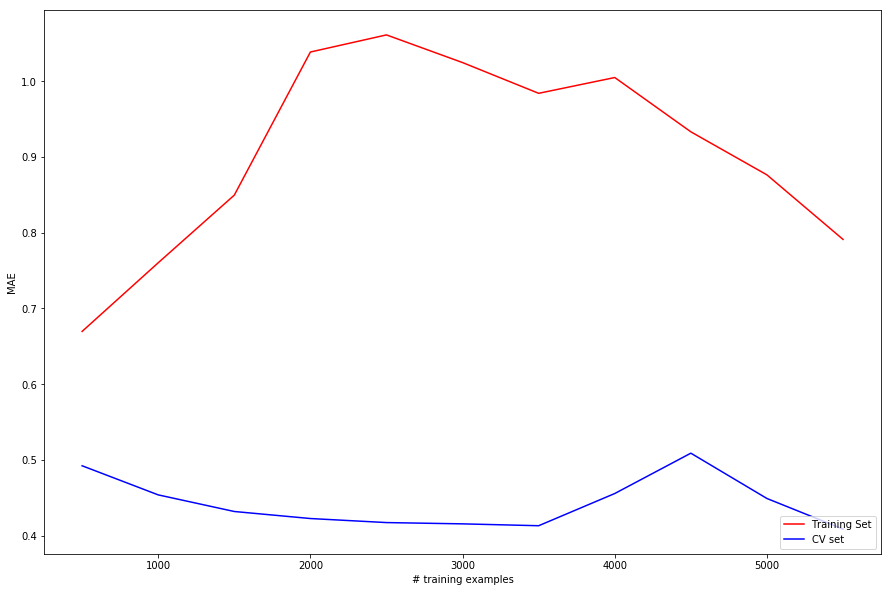

In [36]:
plt.figure(figsize=(15,10))
plt.plot(iterations,scorestrain,'r')
plt.plot(iterations,scorescv, 'b')
plt.xlabel('# training examples')
plt.ylabel('MAE')
plt.legend(['Training Set','CV set'],loc='lower right')